In [1]:
import numpy as np
import pandas as pd
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = anndata.read("../../data/cheng21_cell_scrna/organized/P28NR.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 23930 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [3]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 4044 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [4]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)

In [5]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [6]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(lognorm)

ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [7]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]
# res['type'] = types

Text(0, 0.5, 'explained var')

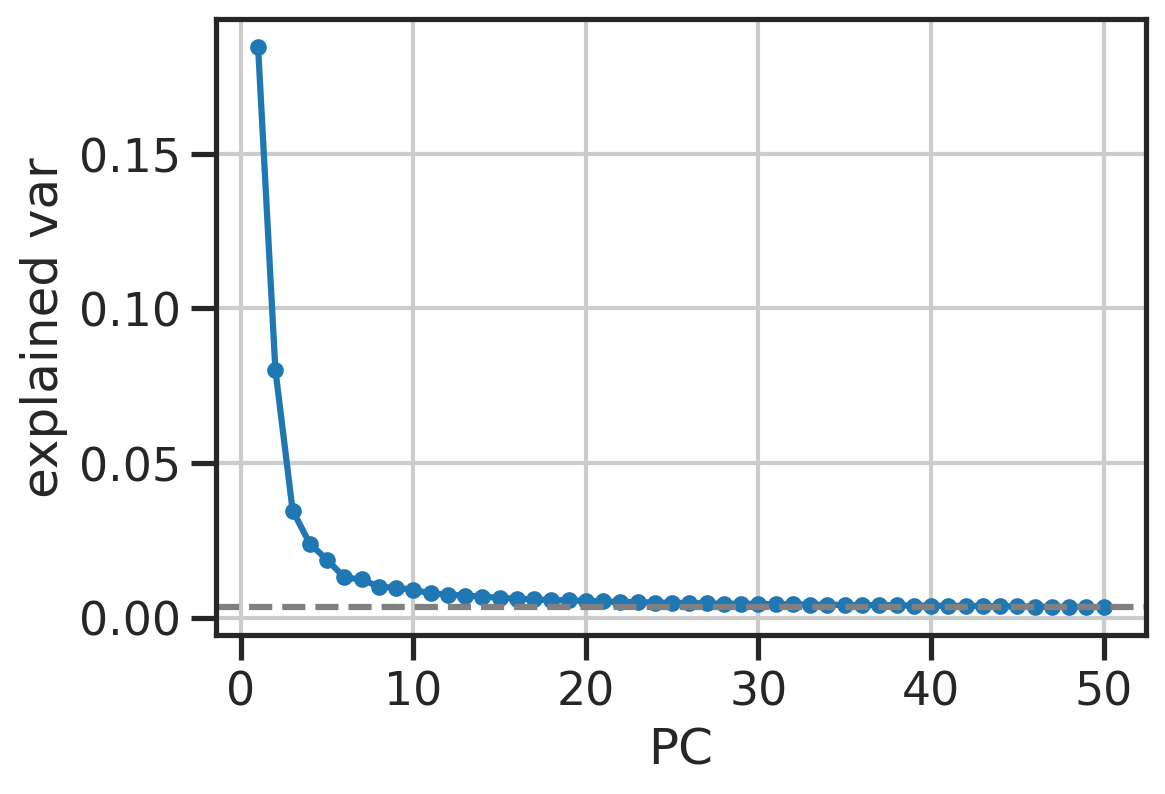

In [8]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

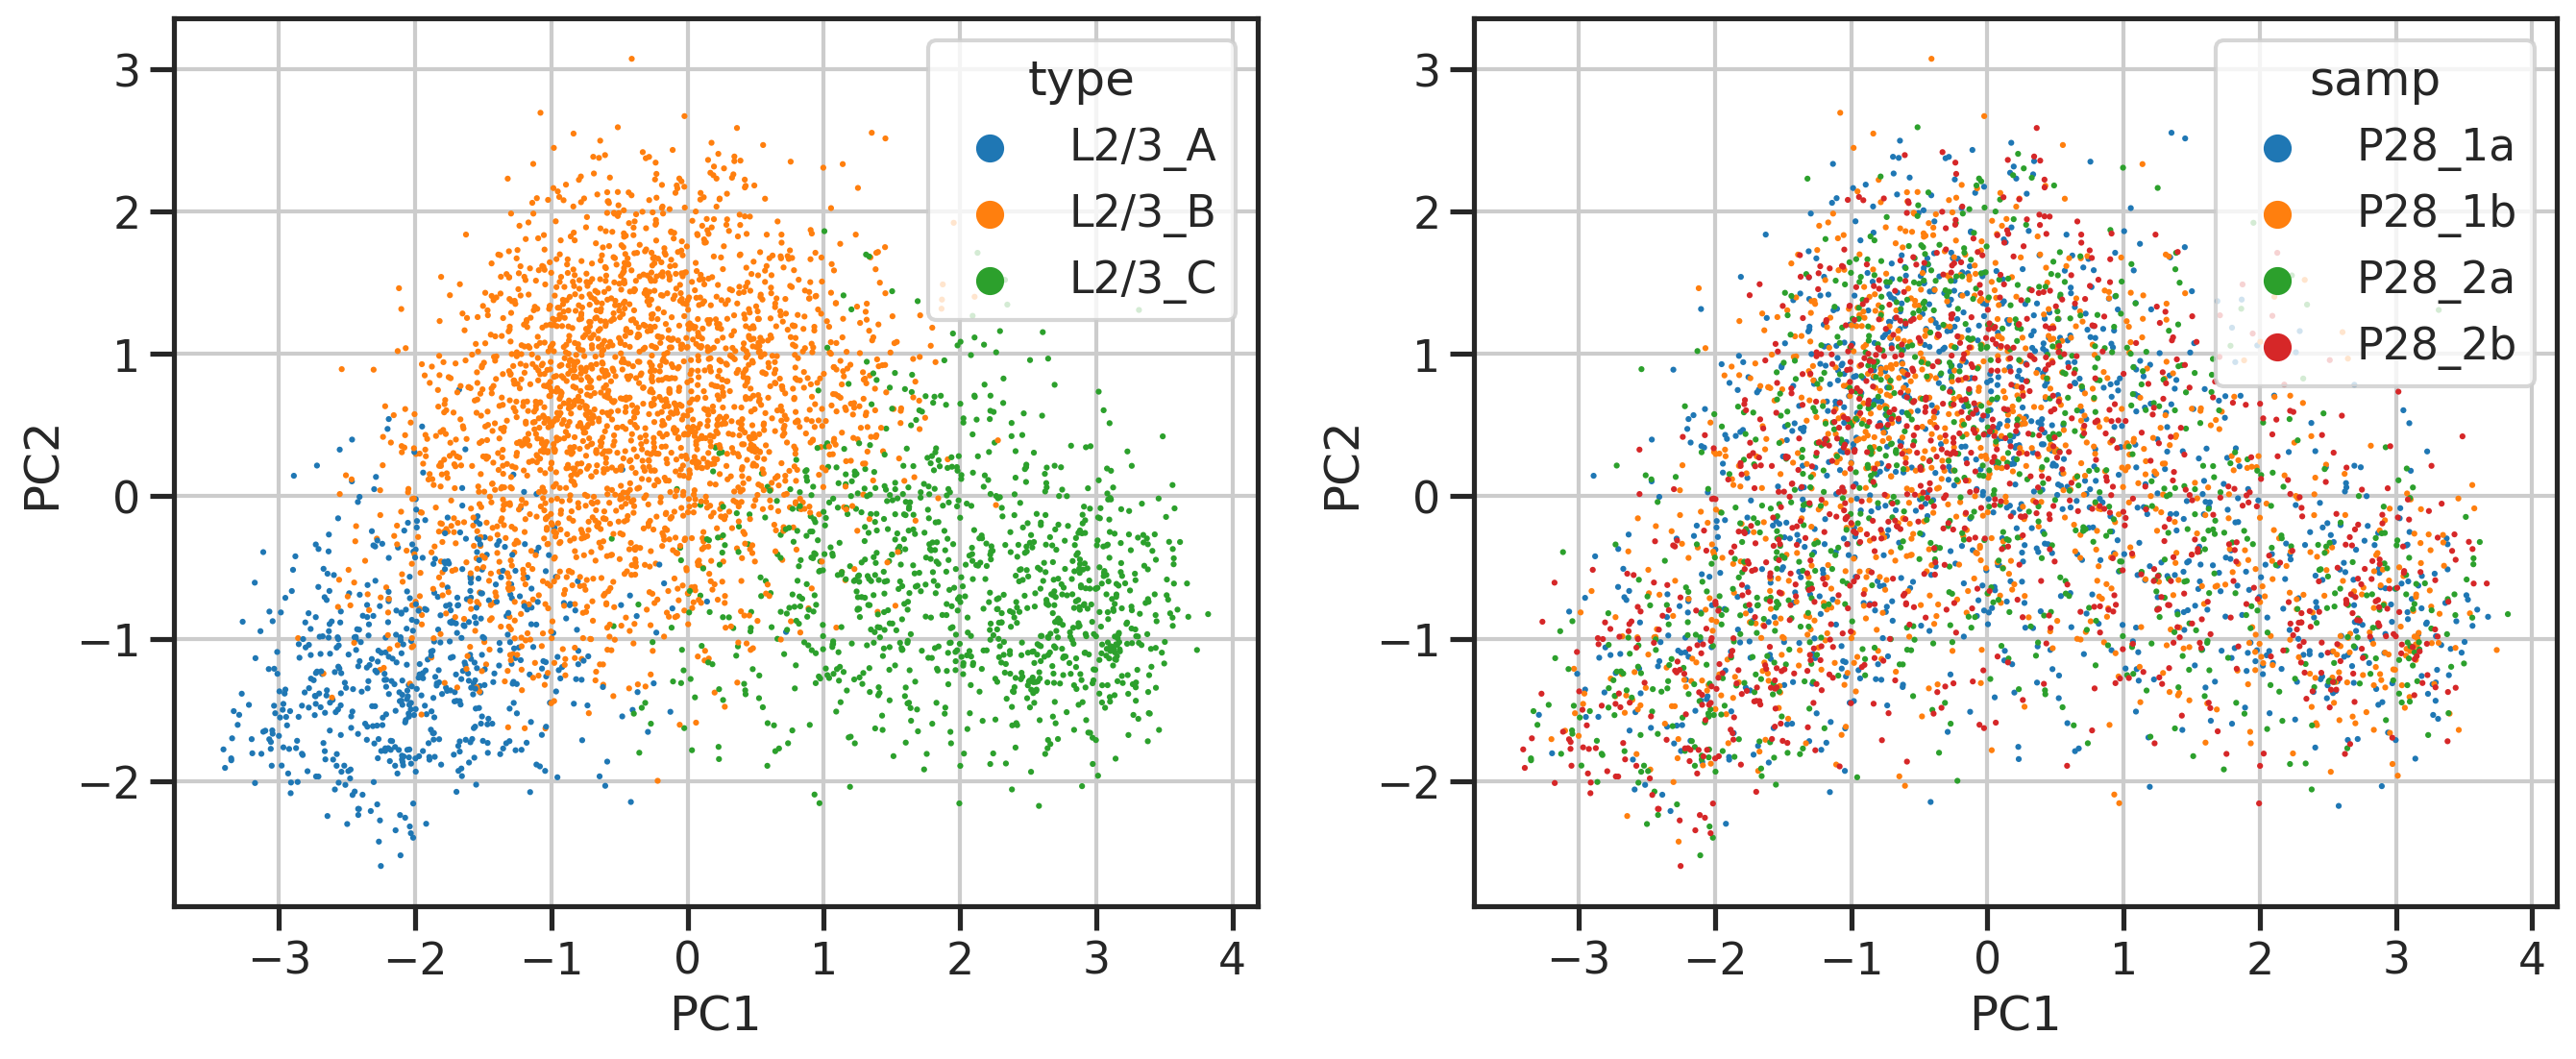

In [9]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

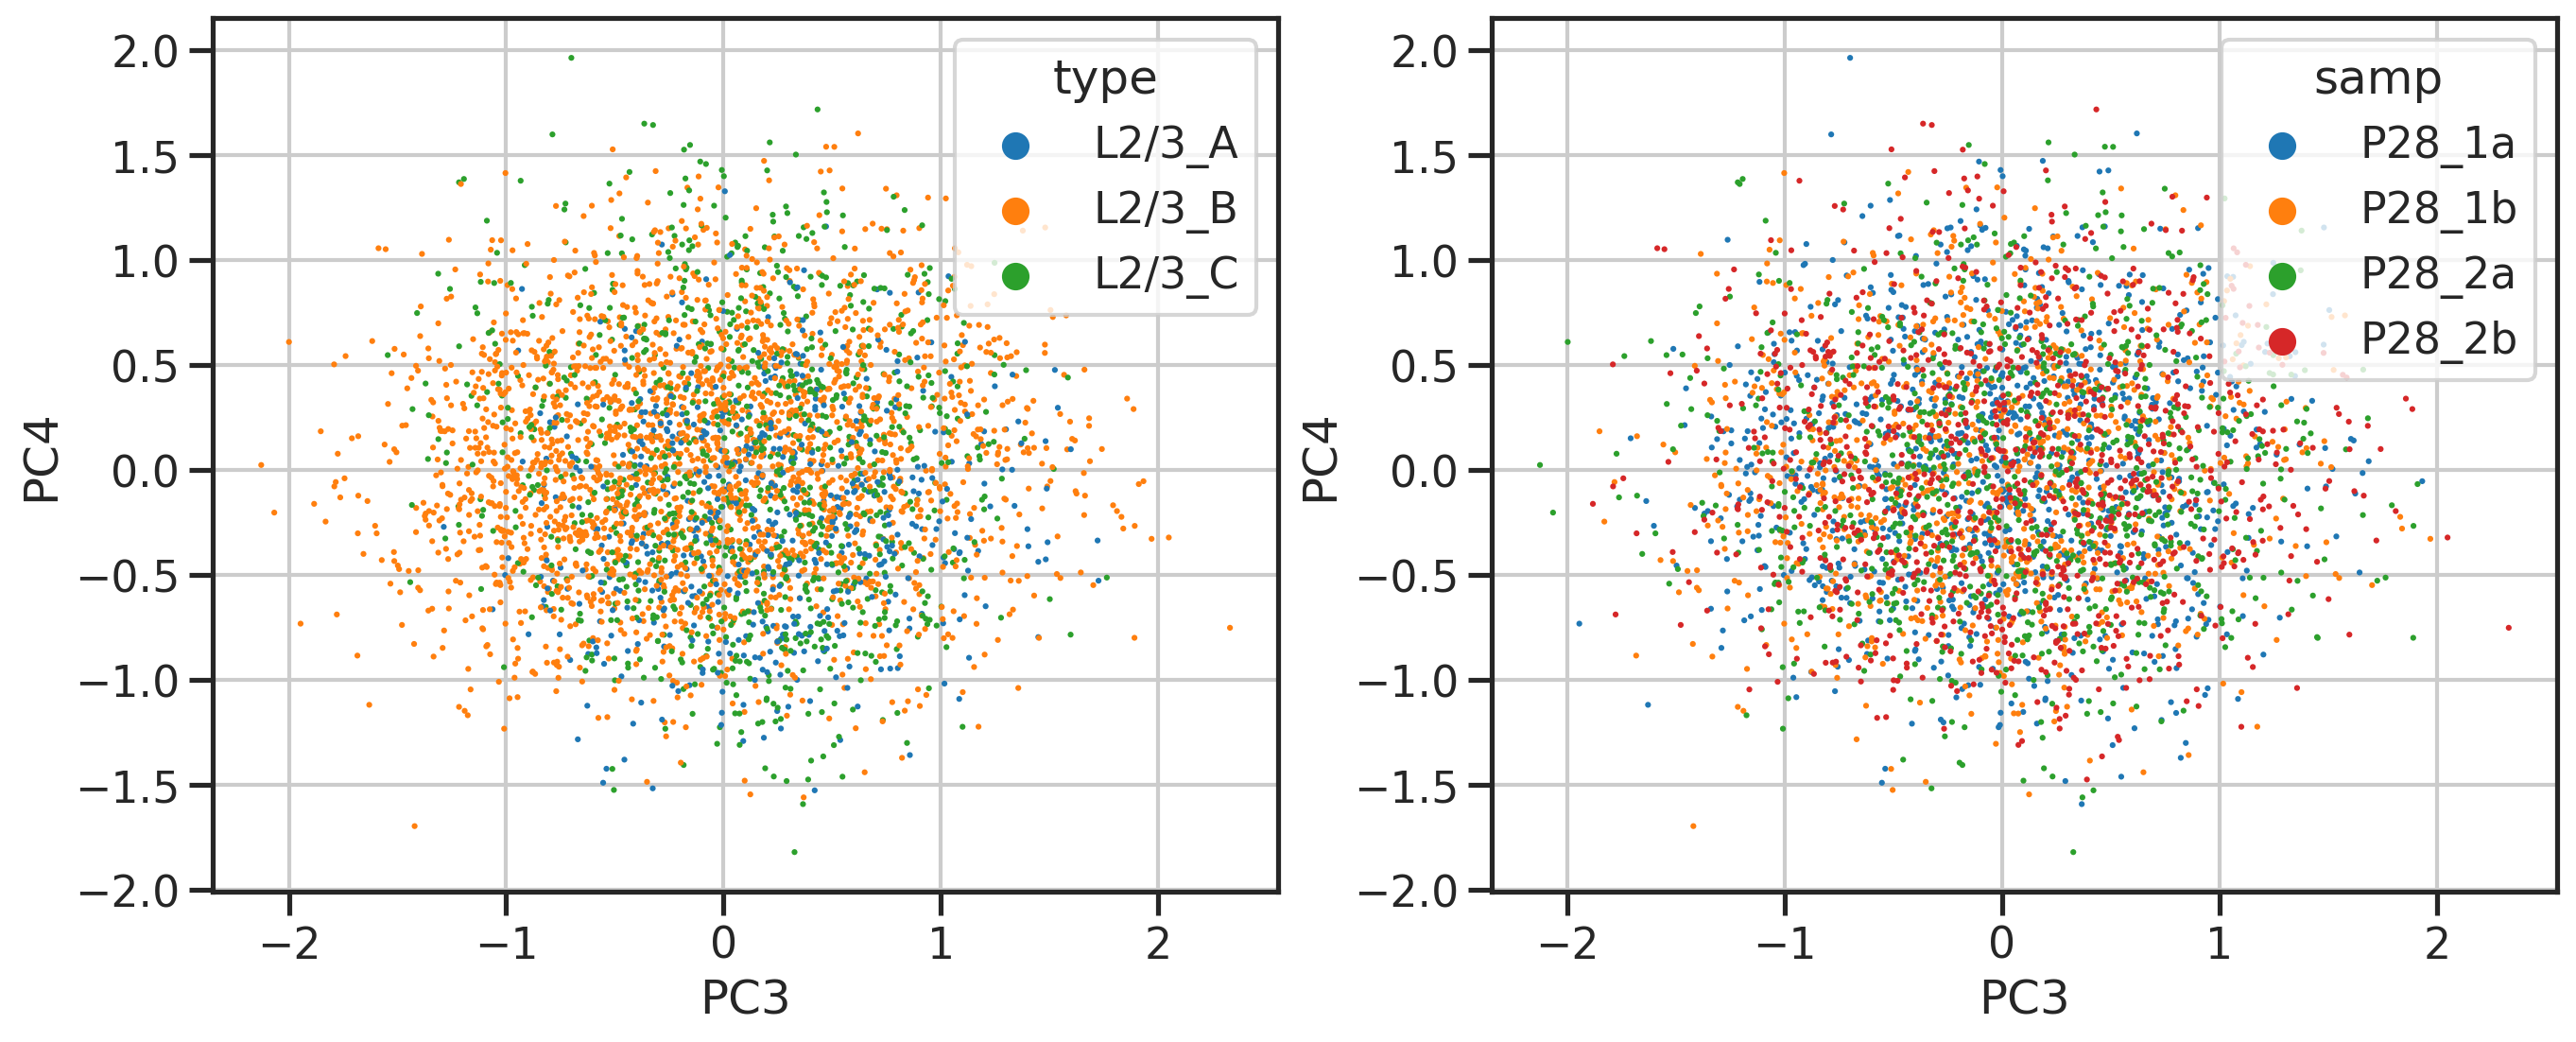

In [10]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

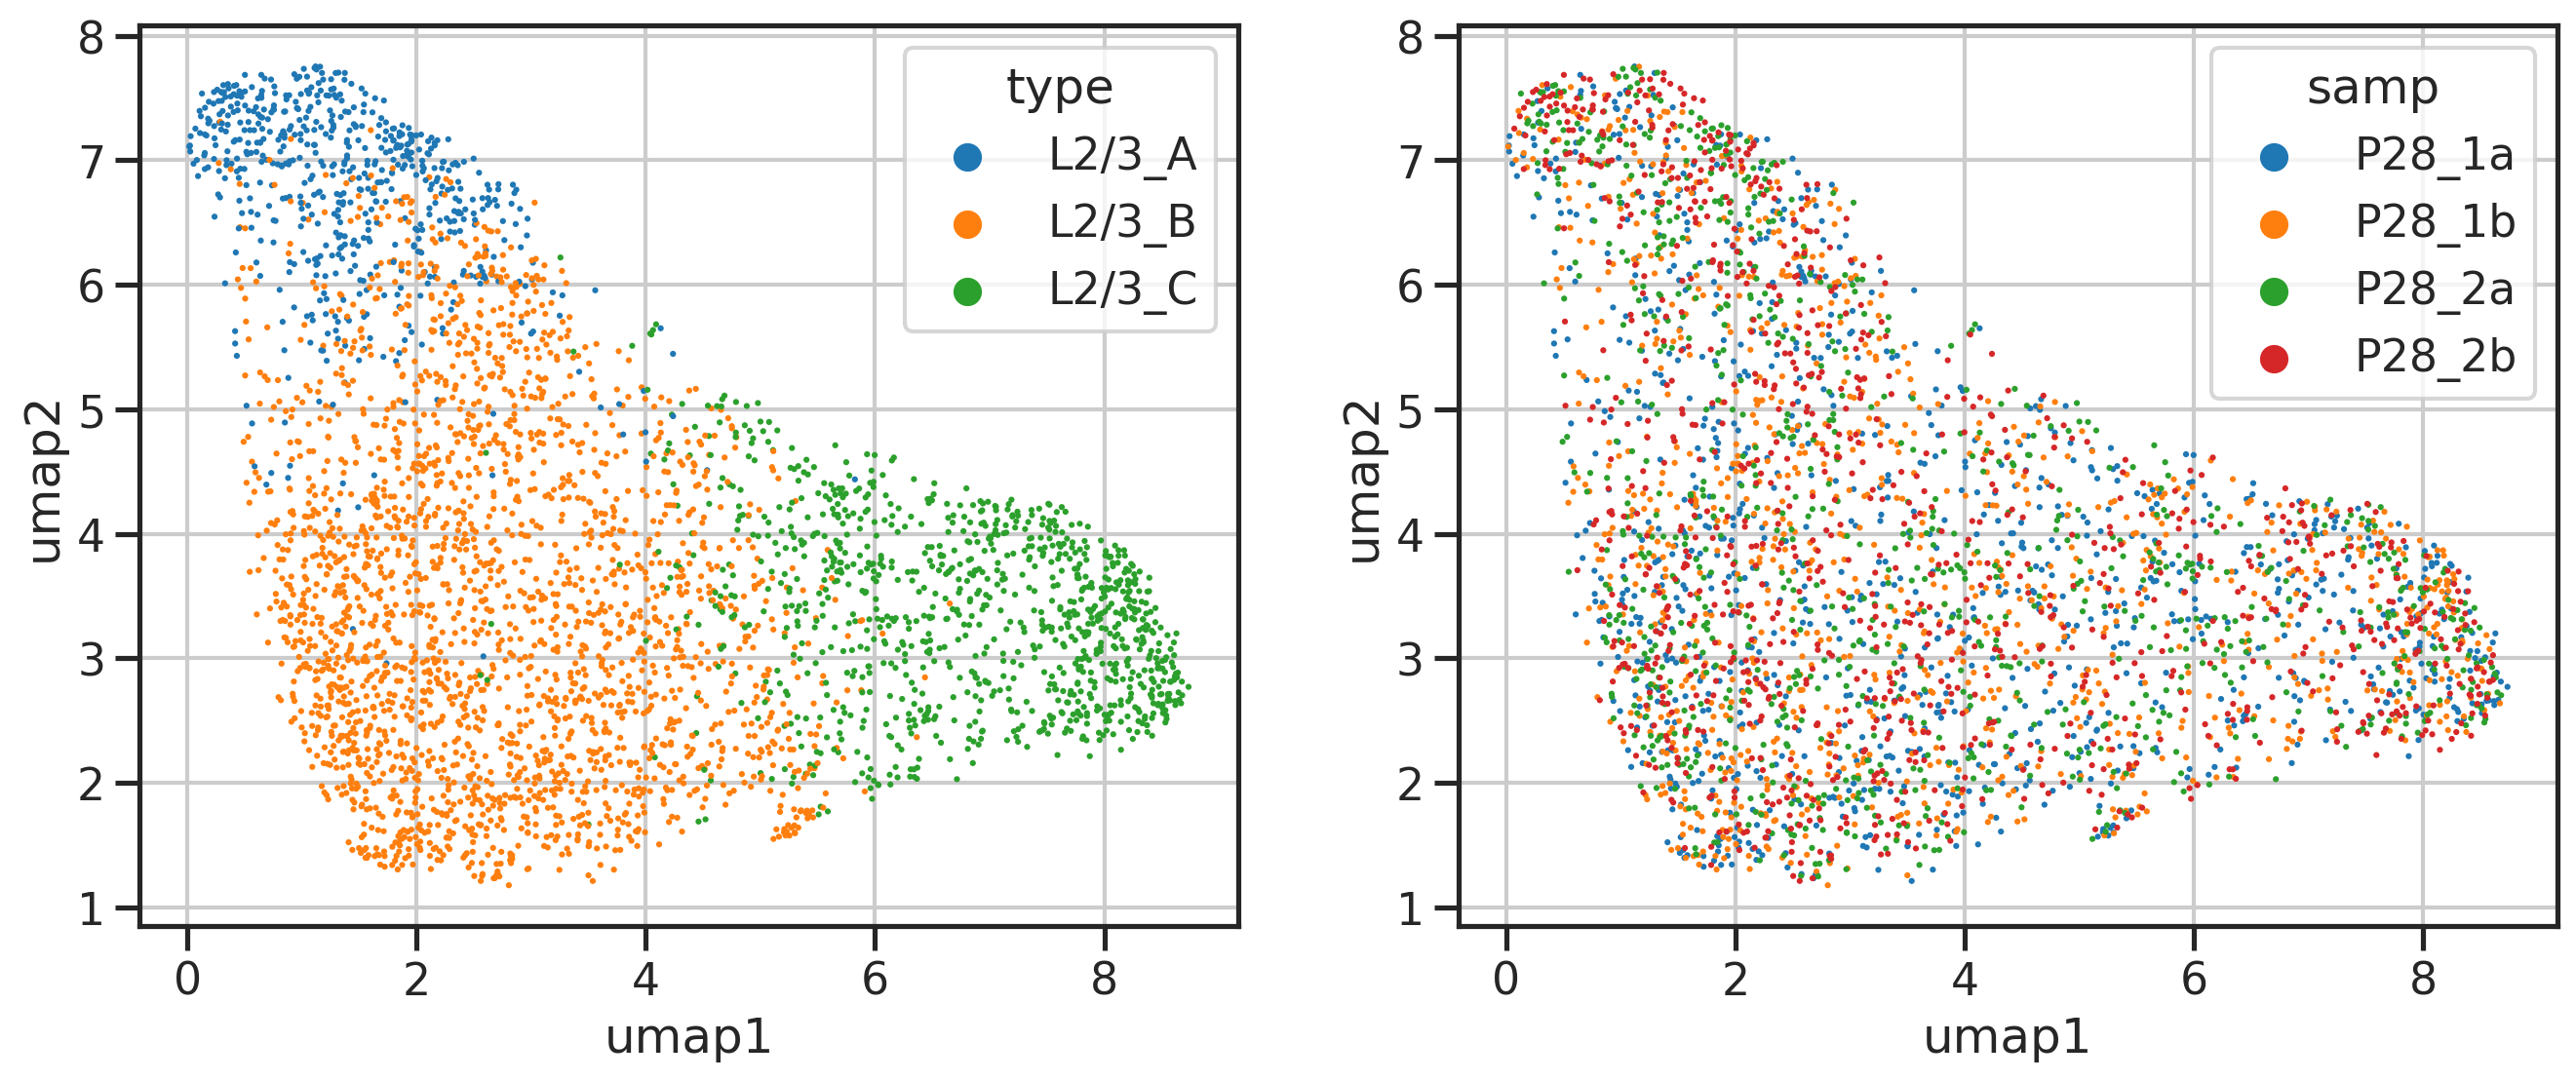

In [11]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [12]:
zlognorm = zscore(lognorm, axis=0) 
rowidx = basicu.order_by_hc(zlognorm)
# colidx = basicu.order_by_hc(zlognorm.T)

In [13]:
my_colors = ('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = ('C0', 'C1', 'C2', 'C3')
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

In [14]:
ncell, ngene = zlognorm.shape

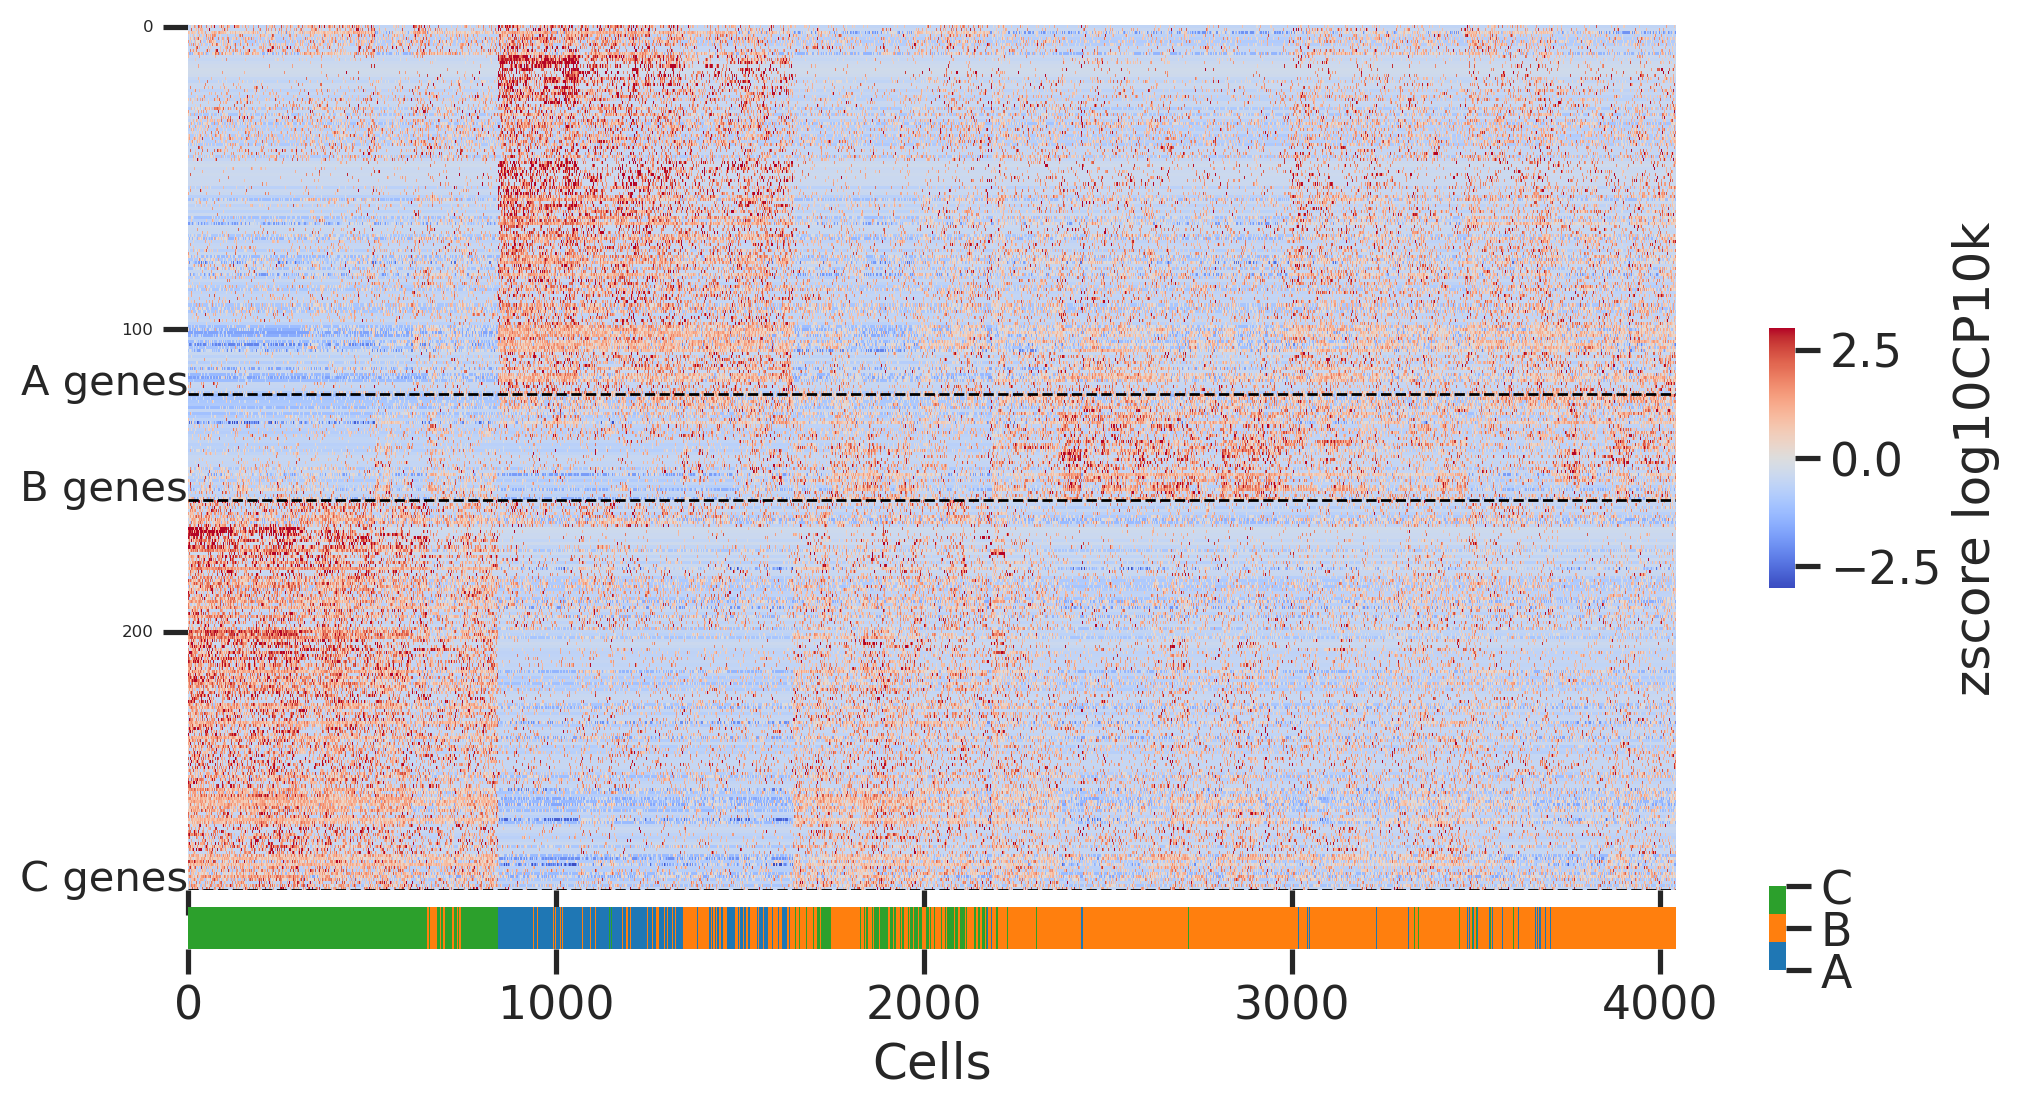

In [15]:
fig, axdict = plt.subplot_mosaic("A\n"*15+"B", figsize=(12,6), sharex=True)
ax = axdict['A']
sns.heatmap(zlognorm[rowidx].T,
            xticklabels=1000,
            yticklabels=100,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            ax=ax,
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=6)

ax.hlines(np.cumsum(gene_type_counts), 0, ncell, linewidth=1, linestyle='--', color='k')
for y, lbl in zip(np.cumsum(gene_type_counts), ['A genes', 'B genes', 'C genes']):
    ax.text(0, y, lbl, fontsize=15, ha='right')

ax = axdict['B']
sns.heatmap(pd.factorize(types[rowidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])

fig.subplots_adjust(hspace=0.4)
plt.show()

# sorting
- give each cell a pseudo-time index
- give each gene a pseudo-time index

# continuous vs discrete